In [13]:
import os
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.mosaicplot import mosaic
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import pairwise_distances


In [14]:
#looking into the dataframe

mcdonalds = pd.read_csv("mcdonalds.csv") 
print(mcdonalds.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [15]:
print(mcdonalds.shape)

(1453, 15)


In [16]:
print(mcdonalds.head(3))

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [17]:
mcdonalds.describe()

,Age
count,1453.000000
mean,44.604955
std,14.221178
min,18.000000
25%,33.000000
50%,45.000000
75%,57.000000
max,71.000000


In [18]:
# Converting  'Yes'/'No' responses to binary 1/0
MD_x = mcdonalds.iloc[:, :11].map(lambda x: 1 if x == "Yes" else 0)
col_means = MD_x.mean().round(2)
print(col_means)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [19]:

# dataframe to calculate pca,std and cumproportion
from sklearn.decomposition import PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

pcasum_df = pd.DataFrame({
    "Principal Component": range(1, len(pca.explained_variance_) + 1),
    "Standard Deviation": pca.explained_variance_,
    "Proportion of Variance": pca.explained_variance_ratio_,
})

pcasum_df["Cumulative Proportion"] = pcasum_df["Proportion of Variance"].cumsum()

pcasum_df = pcasum_df[['Principal Component', 'Standard Deviation',  'Cumulative Proportion','Proportion of Variance',]]

print("Pca Summary:")
print(pcasum_df)

Pca Summary:
    Principal Component  Standard Deviation  Cumulative Proportion  \
0                     1            0.573124               0.299447   
1                     2            0.369002               0.492244   
2                     3            0.254641               0.625290   
3                     4            0.159040               0.708386   
4                     5            0.113842               0.767866   
5                     6            0.096270               0.818166   
6                     7            0.083925               0.862015   
7                     8            0.075692               0.901563   
8                     9            0.070358               0.938323   
9                    10            0.061922               0.970677   
10                   11            0.056123               1.000000   

    Proportion of Variance  
0                 0.299447  
1                 0.192797  
2                 0.133045  
3                 0.083096  
4

In [20]:
#pca of various categories decomposed together
decomposed_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

decomposed_df.index = MD_x.columns

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("PCA decomposed:")
    print(decomposed_df)

PCA decomposed:
             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy       0.48 -0.36  0.30  0.06  0.31 -0.17 -0.28 -0.01 -0.57  0.11 -0.05
convenient  0.16 -0.02  0.06 -0.14 -0.28  0.35 -0.06  0.11  0.02  0.67  0.54
spicy       0.01 -0.02  0.04  0.20 -0.07  0.36  0.71 -0.38 -0.40  0.08 -0.14
fattening  -0.12  0.03  0.32 -0.35  0.07  0.41 -0.39 -0.59  0.16  0.01 -0.25
greasy     -0.30  0.06  0.80  0.25 -0.36 -0.21  0.04  0.14  0.00 -0.01 -0.00
fast        0.11  0.09  0.06 -0.10 -0.11  0.59 -0.09  0.63 -0.17 -0.24 -0.34
cheap       0.34  0.61  0.15  0.12  0.13  0.10 -0.04 -0.14 -0.08 -0.43  0.49
tasty       0.47 -0.31  0.29 -0.00  0.21  0.08  0.36  0.07  0.64 -0.08 -0.02
expensive  -0.33 -0.60 -0.02  0.07  0.00  0.26 -0.07 -0.03 -0.07 -0.45  0.49
healthy     0.21 -0.08 -0.19  0.76 -0.29  0.18 -0.35 -0.18  0.19  0.04 -0.16
disgusting -0.37  0.14  0.09  0.37  0.73  0.21 -0.03  0.17  0.07  0.29  0.04


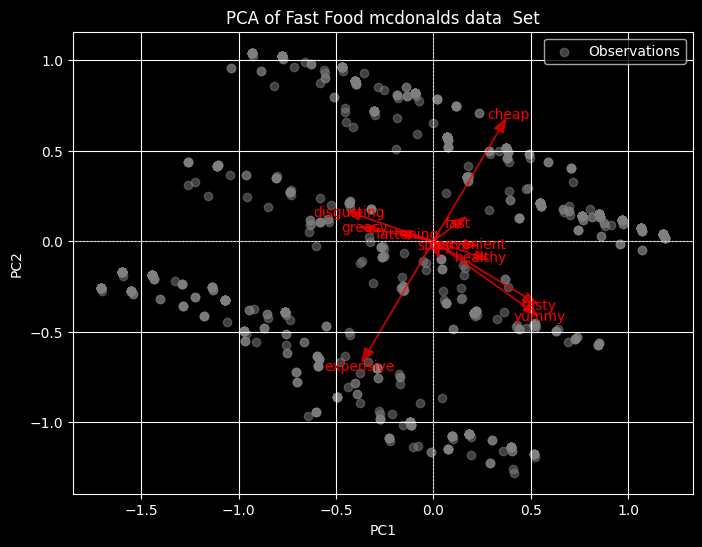

In [21]:
# Fitting the PCA model and obtaining the  scores and scatter_map
pca.fit(MD_x)
scores = pca.transform(MD_x)   
scatter_map = pca.components_.T     
plt.figure(figsize=(8, 6))

# Plot the observations on the first two principal components
plt.scatter(scores[:, 0], scores[:, 1], color='grey', alpha=0.5, label='Observations')
for i in range(scatter_map.shape[0]):
    plt.arrow(0, 0, scatter_map[i, 0], scatter_map[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(scatter_map[i, 0] * 1.15, scatter_map[i, 1] * 1.15, mcdonalds.columns[i], color='red', 
             ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA of Fast Food mcdonalds data  Set')
plt.grid(True)
plt.legend()
plt.show()


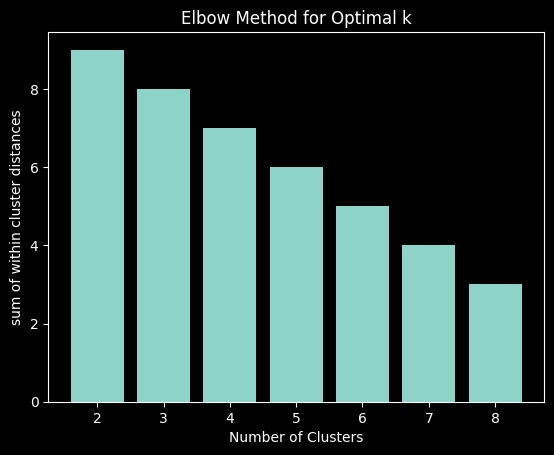

In [22]:
#finding out the best K forr suitable clusters
k_range = range(2, 9)
inertias = []
silhouette_scores = []
k_result = []

for k in k_range:
    model = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = model.fit_predict(decomposed_df)
    inertia = model.inertia_
    silhouette = silhouette_score(decomposed_df, labels)

    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    k_result.append(labels)


plt.bar(k_range, inertias)
plt.grid(False)
plt.xlabel('Number of Clusters')
plt.ylabel('sum of within cluster distances')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()


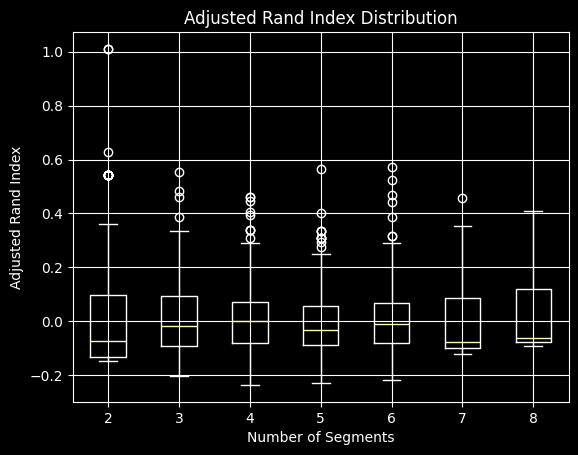

In [23]:
#box plot for global stability of k_means 
boot_n = 200
ARI_scores = []

for label in k_result :
    bootstrap_samples = [np.random.choice(label, size=len(label), replace=True) for _ in range(boot_n)]
    ari_boot = [adjusted_rand_score(label, bootstrap_sample) + 0.01 for bootstrap_sample in bootstrap_samples]
    ARI_scores.append(ari_boot)
plt.boxplot(ARI_scores, tick_labels=range(2, 9))
plt.title('Adjusted Rand Index Distribution')
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.grid(True)
plt.show()

NameError: name 'MD_km28' is not defined

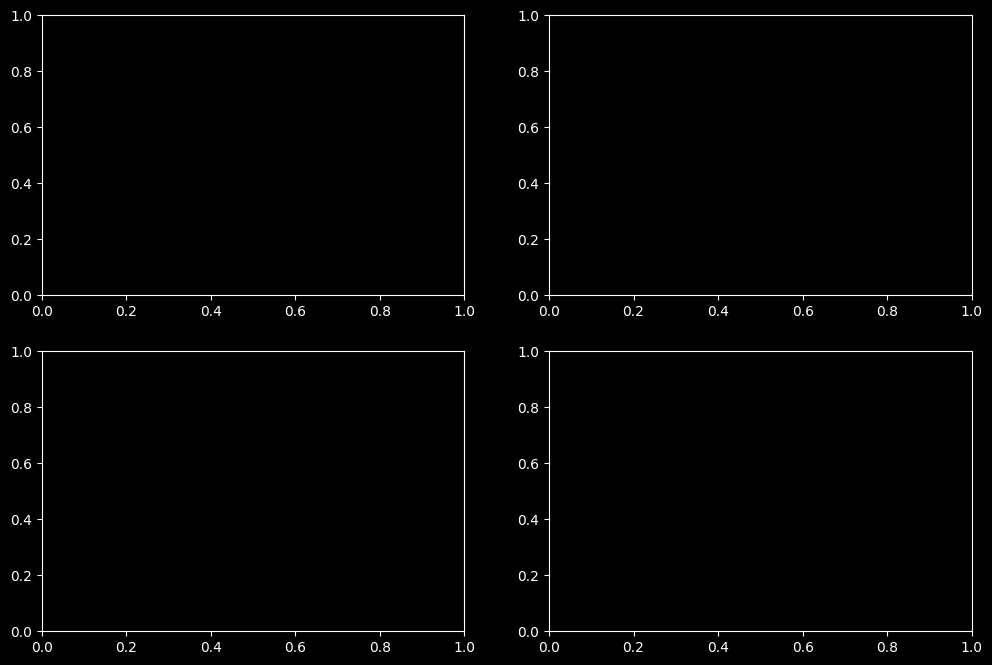

In [24]:
# Updated configuration for histogram plots
similarity_range = (0, 0.9) 
bin_count = 15                
max_hist_frequency = 150      
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Generating  histograms for each clustera
def plot_similarity_histograms(data_set, model_dict, axes_array, bins, range_values, max_freq):
    for cluster_id in range(1, 5):
        
        predicted_labels = model_dict[str(cluster_id)].predict(data_set)
        min_distances = model_dict[str(cluster_id)].transform(data_set).min(axis=1)
        
        # Determining the  subplot position
        row_idx = (cluster_id - 1) // 2
        col_idx = (cluster_id - 1) % 2
        ax = axes_array[row_idx, col_idx]
        
        ax.hist(min_distances, bins=bins, range=range_values, color='skyblue', edgecolor='black')
        ax.set_xlabel('Similarity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Cluster {cluster_id}')

        ax.set_xlim(range_values)
        ax.set_ylim(0, max_freq)
        ax.set_xticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])  # Adjusted ticks for the new range

plot_similarity_histograms(MD_x, MD_km28, axes, bin_count, similarity_range, max_hist_frequency)

plt.tight_layout()
plt.show()


In [ ]:
# Updated segment range and Segment level stability across solutions
n_clusters_range = range(2, 9)
stability_scores = []

# Calculating stability for each clustering solutions
for n_clusters in n_clusters_range:
    cluster_labels = MD_km28[str(n_clusters)].predict(MD_x)  
    stability_scores.append(cluster_labels)

plt.figure(figsize=(10, 6)) 

for idx, n_clusters in enumerate(n_clusters_range):
    stability_values = [
        np.mean(stability_scores[idx] == cluster_label_set)
        for cluster_label_set in stability_scores
    ]
    plt.plot(
        n_clusters_range, stability_values, 
        marker='D', linestyle='--', linewidth=1.5, 
        label=f'Clusters: {n_clusters}'
    )

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Average Stability Score', fontsize=12)
plt.title('Cluster Stability Analysis (CSA) Across Solutions', fontsize=14, fontweight='bold')
plt.xticks(n_clusters_range, fontsize=10)
plt.legend(title="Cluster Solutions")
plt.grid(color='gray', linestyle=':', linewidth=0.5)  

plt.show()


In [ ]:
# Defining the  segment level stability within solutions and initialize result storage 
segment_ids = ["1", "2", "3", "4"]
cluster_labels = {}
cluster_distances = {}

# Compute cluster labels and distances for each segment
def compute_cluster_metrics(data, segment_list, model_dict):
    labels, distances = {}, {}
    for seg in segment_list:
        labels[seg] = model_dict[seg].predict(data)
        distances[seg] = model_dict[seg].transform(data).min(axis=1)
    return labels, distances

# Executing the  clustering metrics computation
cluster_labels, cluster_distances = compute_cluster_metrics(MD_x, segment_ids, MD_km28)

def calculate_stability(distances_dict):
    stability_values = []
    for distances in distances_dict.values():
        normalized_distances = distances / np.max(distances)
        stability_values.append(normalized_distances)
    return stability_values

segment_stability_scores = calculate_stability(cluster_distances)
def plot_stability_scores(stability_scores, segments):
    plt.boxplot(stability_scores, whis=1.5)
    plt.xlabel("Segment Number")
    plt.ylabel("Stability Score")
    plt.xticks(range(1, len(segments) + 1), segments)
    plt.ylim(0, 1)
    plt.title("Segment Stability Across Solutions")
    plt.show()

plot_stability_scores(segment_stability_scores, segment_ids)


In [ ]:
from scipy.stats import entropy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Seed and configuration
np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []

# Model fitting and metric calculations
for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x)  
    
    iter_val = model.n_iter_
    converged = model.n_init == 1 or model.inertia_ < 1e-10
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD_x.shape
    
    # Information Criteria calculations
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k

    # Entropy and ICL (Integrated Complete Likelihood)
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    MD_m28.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))


MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_m28)


In [ ]:

num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')

plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pandas as pd

num_clusters = 4

kmeans_model = KMeans(n_clusters=num_clusters, random_state=1234)
kmeans_model.fit(MD_x)
kmeans_assignments = kmeans_model.predict(MD_x)

# Fitting the  Gaussian Mixture Model and predicting  clusters
gmm_model = GaussianMixture(n_components=num_clusters, random_state=1234)
gmm_model.fit(MD_x)
gmm_assignments = gmm_model.predict(MD_x)

cluster_results = pd.DataFrame({'KMeans': kmeans_assignments, 'GMM': gmm_assignments})

filtered_data = MD_x[cluster_results['GMM'] == 3]

filtered_kmeans_model = KMeans(n_clusters=num_clusters, random_state=1234)
filtered_kmeans_model.fit(filtered_data)
filtered_kmeans_assignments = filtered_kmeans_model.predict(filtered_data)

filtered_results = pd.DataFrame({'KMeans': filtered_kmeans_assignments, 'GMM': 3})

# Cross-tabulation between KMeans and GMM
cross_tab_1 = pd.crosstab(cluster_results['KMeans'], cluster_results['GMM'])
cross_tab_2 = pd.crosstab(cluster_results['KMeans'], filtered_results['KMeans'])

print("Cross-tabulation Results (KMeans vs. GMM):")
print(cross_tab_1)

print("\nCross-tabulation Results (KMeans vs. KMeans for filtered data):")
print(cross_tab_2)


In [ ]:
gmm_ma = GaussianMixture(n_components=4)
gmm_ma.fit(MD_x)

log_likelihood_ma = gmm_ma.score(MD_x)

gmm_m = GaussianMixture(n_components=4)
gmm_m.fit(MD_x)

log_likelihood_m = gmm_m.score(MD_x)

print("Log-likelihood for MD_x.ma:", log_likelihood_ma)
print("Log-likelihood for MD_x.m:", log_likelihood_m)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  

# Extracting the KMeans model for segment 4
kmeans_model_segment4 = MD_km28['4']

# Get labels assigned by the KMeans model
segment_labels = kmeans_model_segment4.labels_

mean_values_per_segment = MD_x.groupby(segment_labels).mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

color_palette = cm.viridis  

# Looping through each segment and plot the mean values
for segment_index in range(mean_values_per_segment.shape[0]):
    num_variables = mean_values_per_segment.shape[1]
    
    for variable_index in range(num_variables):
        color = color_palette(variable_index / num_variables)  
        axes[segment_index // 2, segment_index % 2].barh(variable_index, mean_values_per_segment.iloc[segment_index, variable_index], color=color)

    axes[segment_index // 2, segment_index % 2].set_title(f'Segment {segment_index + 1}')
    axes[segment_index // 2, segment_index % 2].set(ylabel='Variable', xlabel='Mean Value')
    axes[segment_index // 2, segment_index % 2].set_yticks(range(num_variables))
    axes[segment_index // 2, segment_index % 2].set_yticklabels(MD_x.columns)


fig.suptitle('Mean Profiles of Segments')

fig.tight_layout(rect=[0, 0, 0.85, 1])  

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_palette(i / num_variables)) for i in range(num_variables)]
plt.legend(legend_handles, MD_x.columns, loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(MD_x)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

fig, ax = plt.subplots()

ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

In [ ]:
k_4 = KMeans(n_clusters=4, random_state=0)
k_4.fit(df_decomposed)
l_4 = k_4.labels_

plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'd']
edge_colors = ['darkblue', 'orange', 'grey', 'red']

for i in range(4):
    temp = df_decomposed[l_4 == i]
    plt.scatter(
        temp['yummy'],
        temp['convenient'],
        label=i,
        edgecolor=edge_colors[i],
        marker=markers[i],
        facecolor='none',
        alpha=0.5
    )

scale = 1.7

texts = []
for i, j in enumerate(df_decomposed.columns):
    text = plt.text(
        p.components_[0, i] * scale,
        p.components_[1, i] * scale,
        j,
        color='red',
        fontsize=12,
        ha='center',
        va='bottom',
        stretch="expanded"
    )
    texts.append(text)
    plt.arrow(0, 0, p.components_[0, i] * scale, p.components_[1, i] * scale, color='red')
    plt.annotate(
        '', xytext=(0, 0),
        xy=(p.components_[0, i] * scale, p.components_[1, i] * scale),
        arrowprops=dict(
            arrowstyle="->",
            color='red'
        )
    )


plt.scatter(
    p.components_[0, :] * scale,
    p.components_[1, :] * scale,
    s=0.5,
    color='red'
)

plt.grid(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Component Axes')
plt.legend()
plt.show()

In [ ]:
# Define a mapping of string values to numeric codes
sentiment_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

# Map the 'Like' column to numeric values
mcdonalds['Like.n'] = mcdonalds['Like'].map(sentiment_mapping)

like_n_counts = mcdonalds['Like.n'].value_counts().reset_index()
like_n_counts.columns = ['Numeric Value', 'Count']

print("Numeric Value | Count")
print("-" * 20)
for index, row in like_n_counts.iterrows():
    print(f"{row['Numeric Value']: <15} | {row['Count']}")


In [ ]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Label encoding for categorical columns - Converting 11 columns with yes/no
def encode_labels(column):
    mcdonalds[column] = LabelEncoder().fit_transform(mcdonalds[column])
    return mcdonalds

# List of categorical columns to encode
categorical_columns = [
    'yummy', 'convenient', 'spicy', 'fattening', 'greasy',
    'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting'
]

for column in categorical_columns:
    encode_labels(column)

selected_mcdonalds = mcdonalds.loc[:, categorical_columns]

# Fitting KMeans clustering
kmeans_model = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(selected_mcdonalds)
mcdonalds['cluster_label'] = kmeans_model.labels_

unique_like_categories = mcdonalds['Like'].unique()

crosstab_result = pd.crosstab(mcdonalds['cluster_label'], mcdonalds['Like'])

crosstab_result = crosstab_result[unique_like_categories]

# Plotting
plt.rcParams['figure.figsize'] = (7, 5)
mosaic(crosstab_result.stack())
plt.title('Mosaic Plot of Clusters vs Like Values')
plt.xlabel('Clusters')
plt.ylabel('Like Values')
plt.show()


In [ ]:
#cross tabulation of segment and gender
MD_k4=MD_km28['4']
k4 = MD_k4.labels_

ct = pd.crosstab(k4, mcdonalds['Gender'])
ct
mosaic(ct.stack(),gap=0.01)

plt.show()

In [ ]:
#box and whisker plot for age and segment
data = {
    'segment': labels,
    'Age': mcdonalds.Age
}
dff = pd.DataFrame(data)

plt.figure(figsize=(9, 5))
sns.boxplot(x='segment', y='Age', data=dff)
plt.xlabel('Segment')
plt.ylabel('Age')
plt.title('Box-and-Whisker Plot of Age by Segment')

plt.show()

In [ ]:
#grouping 
mcdonalds['VisitFrequency'] = LabelEncoder().fit_transform(mcdonalds['VisitFrequency'])
visit = mcdonalds.groupby('cluster_label')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()
visit

In [ ]:
mcdonalds['Like'] = LabelEncoder().fit_transform(mcdonalds['Like'])
Like = mcdonalds.groupby('cluster_label')['Like'].mean()
Like = Like.to_frame().reset_index()
Like

In [ ]:
mcdonalds['Gender'] = LabelEncoder().fit_transform(mcdonalds['Gender'])
Gender = mcdonalds.groupby('cluster_label')['Gender'].mean()
Gender = Gender.to_frame().reset_index()
Gender

In [ ]:
# Scatter Plot for Segment Evaluation
mcdonalds['VisitFrequency'] = LabelEncoder().fit_transform(mcdonalds['VisitFrequency'])
visit = mcdonalds.groupby('cluster_label')['VisitFrequency'].mean().reset_index()
mcdonalds['Like'] = LabelEncoder().fit_transform(mcdonalds['Like'])
Like = mcdonalds.groupby('cluster_label')['Like'].mean().reset_index()
mcdonalds['Gender'] = LabelEncoder().fit_transform(mcdonalds['Gender'])
Gender = mcdonalds.groupby('cluster_label')['Gender'].mean().reset_index()
segment = Gender.merge(Like, on='cluster_label', how='left').merge(visit, on='cluster_label', how='left')
segment
plt.figure(figsize = (9,4))
sns.scatterplot(x = "VisitFrequency", y = "Like",data=segment,s=1000, color="blue")
plt.title("Simple segment evaluation plot for the fast food mcdonalds set",fontsize = 15)
plt.xlabel("Visit", fontsize = 14)
plt.ylabel("Like", fontsize = 14)
plt.show()